# Elevating Policy-Making
*Lessons from feedback control theory*

Tom Prescott<br>DS Chat 31 May 2024

## Only Reject

- This is a rewrite of a paper I wrote at the Turing
- A proud **desk-reject** 🙅‍♂
- Could I have selected a better audience? Maybe Dom's weirdos.

## Shocks & Resilience

>The pandemic has brought into focus the fact that resilience in one policy area (e.g. health) can come at the cost of resilience in another (e.g. the economy). The overall aim of this large-scale, 2-year research project is to develop a better understanding of resilience in interconnected health, social, and economic systems and to use this understanding to identify robust policy measures.

### "Lessons from Feedback Control Theory"

The idea: an extended analogy (with a punning title).
- A public service.
- The *shock*: a pandemic; a Brexit; a step change in inflation.
- The *resilience*: the service quickly rejects the shock.
- How?

### "Lessons from Feedback Control Theory"

The idea: an extended analogy (with a punning title).
- A lift.
- The *shock*: someone steps in.
- The *resilience*: the shock is absorbed and quickly rejected.
- How?

# Control

More specifically...

# PID Feedback Control

- Proportional
- Integral
- Derivative

In [1]:
using Pkg
Pkg.activate("../julia/envs/20240531_DS_Chat")
Pkg.add([
        "DifferentialEquations",
        "Plots",
        "ForwardDiff",
        "Polynomials"
    ]
)

  Activating project at `~/code/julia/envs/20240531_DS_Chat`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/code/julia/envs/20240531_DS_Chat/Project.toml`
  No Changes to `~/code/julia/envs/20240531_DS_Chat/Manifest.toml`


In [2]:
using DifferentialEquations
using Plots
using ForwardDiff
using Polynomials

const GRAVITY = 9.81 # m/s

9.81

In [3]:
struct Person
    weight::Float64
    entry::Float64
    exit::Float64
end
Person(w, t0=0) = Person(w, t0, Inf)

# Define the weight of a person in the lift as a function of time
weight(p::Person, t::Real) = p.weight * (p.entry <= t <= p.exit)
weight(p::Person, ts) = p.weight .* (p.entry .<= ts .<= p.exit)

weight (generic function with 2 methods)

In [4]:
Load = Vector{Person}

# Define the weight of a load as a function of time
weight(l::Load, t) = sum(Base.Fix2(weight, t), l)
(l::Load)(t) = weight(l, t)

# Get the times at which load changes
function tstops(l::Load)
    if isempty(l)
        return [0.0]
    else
        ts = mapreduce(p -> [p.entry, p.exit], vcat, l, init=Float64[])
        filter!(isfinite, ts)
        filter!(>(0), ts)
        sort!(ts)
        return ts
    end
end

tstops (generic function with 1 method)

In [5]:
struct Lift
    car_weight::Float64
    counter_weight::Float64
end
Lift(car_weight) = Lift(car_weight, car_weight)
weight(l::Lift) = l.car_weight + l.counter_weight

weight (generic function with 4 methods)

In [6]:
abstract type AbstractReferenceTrajectory end
position(ref::AbstractReferenceTrajectory, t) = ref.position(t)
function velocity(ref::AbstractReferenceTrajectory, t) 
    x = Base.Fix1(position, ref)
    return ForwardDiff.derivative(x, t)
end
function acceleration(ref::AbstractReferenceTrajectory, t)
    dx = Base.Fix1(velocity, ref)
    return ForwardDiff.derivative(dx, t)
end
tstops(ref::AbstractReferenceTrajectory) = Float64[]

struct ReferenceTrajectory{T} <: AbstractReferenceTrajectory
    position::T
end

struct ConstantPosition{H <: Real} <: AbstractReferenceTrajectory
    h::H
end
position(ref::ConstantPosition, t) = ref.h
velocity(::ConstantPosition{H}, t) where H = zero(H)
acceleration(::ConstantPosition{H}, t) where H = zero(H)

acceleration (generic function with 2 methods)

In [7]:
function feedforward_controller(lift::Lift, reference::AbstractReferenceTrajectory)
    M = weight(lift)
    nominal_upward_force = GRAVITY*(lift.counter_weight - lift.car_weight)
    torque_force = t -> M*acceleration(reference, t) - nominal_upward_force
    return torque_force
end

feedforward_controller (generic function with 1 method)

In [8]:
struct ControlledLoadedLift{R <: AbstractReferenceTrajectory}
    lift::Lift
    load::Load
    reference::R
end

mass(x::ControlledLoadedLift, t) = weight(x.lift) + weight(x.load, t)
open_loop_forces(x::ControlledLoadedLift, t) = GRAVITY * (x.lift.counter_weight - x.lift.car_weight - weight(x.load, t))
feedforward_controller(x::ControlledLoadedLift, t) = feedforward_controller(x.lift, x.reference)(t)
tstops(x::ControlledLoadedLift) = sort(vcat(tstops(x.load), tstops(x.reference)))

tstops (generic function with 3 methods)

In [9]:
function dynamics(x::ControlledLoadedLift)
    _open_loop_forces = Base.Fix1(open_loop_forces, x)
    _mass = Base.Fix1(mass, x)
    _feedforward_controller = Base.Fix1(feedforward_controller, x)
    _reference_position = Base.Fix1(position, x.reference)
    _reference_velocity = Base.Fix1(velocity, x.reference)
    fun = function (du, u, gains, t)
        pos = u[1]
        vel = u[2]

        proportional_error = pos - _reference_position(t)
        integral_error = u[3]
        derivative_error = vel - _reference_velocity(t)

        net_force = _open_loop_forces(t)
        net_force += _feedforward_controller(t)
        net_force -= get(gains, :proportional, 0) * proportional_error
        net_force -= get(gains, :integral, 0) * integral_error
        net_force -= get(gains, :derivative, 0) * derivative_error

        du[1] = vel
        du[3] = proportional_error
        du[2] = net_force / _mass(t)
        return
    end
    return fun
end

dynamics (generic function with 1 method)

In [10]:
function trajectory(x::ControlledLoadedLift, T_final=60; gains...)
    f = dynamics(x)
    initial_conditions = [position(x.reference, 0), velocity(x.reference, 0), 0]
    prob = ODEProblem(f, initial_conditions, (0.0, T_final), NamedTuple(gains))

    stops = tstops(x.load)
    sol = solve(prob, 
        alg_hints=[:stiff], 
        tstops = tstops(x.load)
    )

    controlled_position = t -> sol(t, idxs=1)
    controlled_velocity = t -> sol(t, idxs=2)
    p_error = t -> controlled_position(t) - position(x.reference, t)
    p_control = t -> -get(gains, :proportional, 0)*p_error(t)
    i_error = t -> sol(t, idxs=3)
    i_control = t -> -get(gains, :integral, 0)*i_error(t)
    d_error = t -> controlled_velocity(t) - velocity(x.reference, t)
    d_control = t -> -get(gains, :derivative, 0)*d_error(t)
    pid = t -> p_control(t) + i_control(t) + d_control(t)
    ff = f._feedforward_controller

    output = (
        ts = sol.t,
        position=controlled_position,
        velocity=controlled_velocity,
        reference=x.reference,
        error = (
            p=p_error,
            i=i_error,
            d=d_error,
        ),
        control = (
            p=p_control,
            i=i_control,
            d=d_control,
            pid=pid,
            ff=ff,
        ),
    )
    return output
end

trajectory (generic function with 2 methods)

In [17]:
# Define a lift with a mass (kg)
lift = Lift(500)

# Define people going in and out of the lift with mass (kg), entry time (s), exit time (s)
tom = Person(75, 5, 43)
kate = Person(70, 15, 40)
load = [tom, kate]

# Define what you want the lift to be doing: default is resting at height zero
at_rest = ConstantPosition(0.0)

# Put these together into the controlled object
system = ControlledLoadedLift(lift, load, at_rest)

ControlledLoadedLift{ConstantPosition{Float64}}(Lift(500.0, 500.0), Person[Person(75.0, 5.0, 43.0), Person(70.0, 15.0, 40.0)], ConstantPosition{Float64}(0.0))

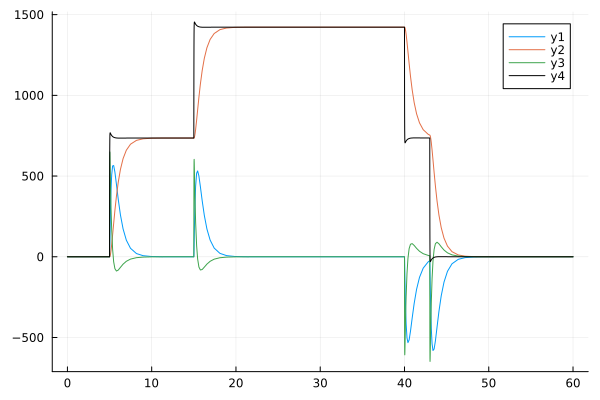

In [54]:
sol = trajectory(system,
    proportional = 500_000, 
    derivative = 100_000, 
    integral = 500_000)
plot(sol.ts, sol.control.p)
plot!(sol.ts, sol.control.i)
plot!(sol.ts, sol.control.d)
plot!(sol.ts, sol.control.pid, color=:black)

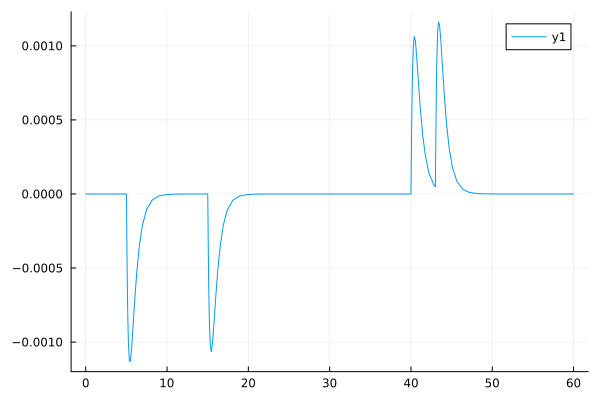

In [55]:
plot(sol.ts, sol.position)

In [13]:
struct SmoothRide <: AbstractReferenceTrajectory
    tA::Float64
    tB::Float64
    hA::Float64
    hB::Float64
    transition::Polynomial
end

function SmoothRide(A::Tuple{Real, Real}, B::Tuple{Real, Real})
    tA, hA = A
    tB, hB = B
    M = [
        1 tA tA^2 tA^3 tA^4 tA^5;
        1 tB tB^2 tB^3 tB^4 tB^5;
        0 1 2*tA 3*tA^2 4*tA^3 5*tA^4;
        0 1 2*tB 3*tB^2 4*tB^3 5*tB^4;
        0 0 2 6*tA 12*tA 20*tA^3;
        0 0 2 6*tB 12*tB 20*tB^3
        ]
    v = [hA, hB, 0, 0, 0, 0]
    transition = Polynomial(M \ v)
    return SmoothRide(tA, tB, hA, hB, transition)
end

position(ref::SmoothRide, t) = (ref.hA * (t < ref.tA)) + (ref.hB * (t > ref.tB)) + ref.transition(t)*(ref.tA <= t <= ref.tB)
function velocity(ref::SmoothRide, t) 
    d_transition = derivative(ref.transition)
    return d_transition(t)*(ref.tA <= t <= ref.tB)
end
function acceleration(ref::SmoothRide, t)
    d2_transition = derivative(ref.transition, 2)
    return d2_transition(t)*(ref.tA <= 1 <= ref.tB)
end
tstops(ref::SmoothRide) = [ref.tA, ref.tB]

tstops (generic function with 4 methods)

In [14]:
system = ControlledLoadedLift(
    lift, 
    [Person(75,5,60)], 
    SmoothRide((10, 0), (40, 3))
)

ControlledLoadedLift{SmoothRide}(Lift(500.0, 500.0), Person[Person(75.0, 5.0, 60.0)], SmoothRide(10.0, 40.0, 0.0, 3.0, Polynomial(-0.6534148827726804 + 0.18756371049949028*x - 0.01834862385321101*x^2 + 0.0006472986748216106*x^3 - 2.5484199796126405e-6*x^4 - 9.174311926605505e-8*x^5)))

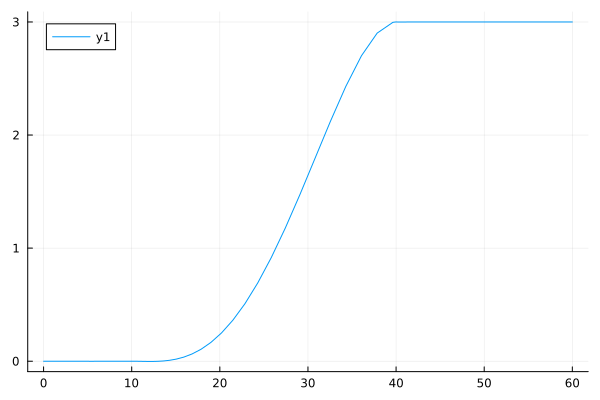

In [15]:
sol = trajectory(
    system,
    proportional = 1_000_000, 
    derivative = 100_000, 
    integral = 500_000,
)
plot(sol.ts, sol.position)